In [1]:
import torch
from utils import DataManager, dataset_sizes, collect_training_data, compute_statistics, compute_average_accuracies
import matplotlib.pyplot as plt
from probes import CCSProbe, TTPD, LRProbe, MMProbe
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import pandas as pd

In [2]:
# hyperparameters
model_family = 'Llama3' # options are 'Llama3', 'Llama2', 'Gemma', 'Gemma2' or 'Mistral'
model_size = '8B'
model_type = 'chat' # options are 'chat' or 'base'
layer = 12 # layer from which to extract activations

device = 'cuda:1' if torch.cuda.is_available() else 'cpu' # gpu speeds up CCS training a fair bit but is not required
device

'cuda:1'

In [3]:
# define datasets used for training
train_sets = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans", "inventors", "neg_inventors", "animal_class",
                  "neg_animal_class", "element_symb", "neg_element_symb", "facts", "neg_facts"]
# get size of each training dataset to include an equal number of statements from each topic in training data
train_set_sizes = dataset_sizes(train_sets) 

### Unseen topics

In [4]:
# compare TTPD, LR and CCS on topic-specific datasets
probe_types = [TTPD, LRProbe, CCSProbe, MMProbe]
results = {TTPD: defaultdict(list), LRProbe: defaultdict(list), CCSProbe: defaultdict(list), MMProbe: defaultdict(list)}
num_iter = 20

total_iterations = len(probe_types) * num_iter * len(train_sets)
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_type in probe_types:
        for n in range(num_iter):
            indices = np.arange(0, 12, 2)
            for i in indices:
                cv_train_sets = np.delete(np.array(train_sets), [i, i+1], axis=0)
                # load training data
                acts_centered, acts, labels, polarities= collect_training_data(cv_train_sets, train_set_sizes, model_family,
                                                                                model_size, model_type, layer)
                if probe_type == TTPD:
                    probe = TTPD.from_data(acts_centered, acts, labels, polarities)
                if probe_type == LRProbe:
                    probe = LRProbe.from_data(acts, labels)
                if probe_type == CCSProbe:
                    acts_affirm = acts[polarities == 1.0]
                    acts_neg = acts[polarities == -1.0]
                    labels_affirm = labels[polarities == 1.0]
                    mean_affirm = torch.mean(acts_affirm, dim=0) 
                    mean_neg = torch.mean(acts_neg, dim=0)
                    acts_affirm = acts_affirm - mean_affirm
                    acts_neg = acts_neg - mean_neg
                    probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
                if probe_type == MMProbe:
                    probe = MMProbe.from_data(acts, labels)

                # evaluate classification accuracy on held out datasets
                dm = DataManager()
                for j in range(0,2):
                    dm.add_dataset(train_sets[i+j], model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                    acts, labels = dm.data[train_sets[i+j]]
                    
                    # classifier specific predictions
                    if probe_type == CCSProbe:
                        if j == 0:
                            acts = acts - mean_affirm
                        if j == 1:
                            acts = acts - mean_neg
                    predictions = probe.pred(acts)
                    results[probe_type][train_sets[i+j]].append((predictions == labels).float().mean().item())
                    pbar.update(1)

stat_results = compute_statistics(results)

# Compute mean accuracies and standard deviations for each probe type
probe_accuracies = compute_average_accuracies(results, num_iter)

for probe_type, stats in probe_accuracies.items():
    print(f"{probe_type}:")
    print(f"  Mean Accuracy: {stats['mean']*100:.2f}%")
    print(f"  Standard Deviation of the mean accuracy: {stats['std_dev']*100:.2f}%")

Training and evaluating classifiers:  50%|████▉     | 479/960 [02:01<01:46,  4.51it/s]/export/home/lbuerger/miniconda3/envs/truth_is_universal/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Training and evaluating classifiers: 100%|██████████| 960/960 [05:11<00:00,  3.09it/s]

TTPD:
  Mean Accuracy: 93.96%
  Standard Deviation of the mean accuracy: 0.23%
LRProbe:
  Mean Accuracy: 94.58%
  Standard Deviation of the mean accuracy: 0.60%
CCSProbe:
  Mean Accuracy: 83.03%
  Standard Deviation of the mean accuracy: 7.31%
MMProbe:
  Mean Accuracy: 92.13%
  Standard Deviation of the mean accuracy: 0.28%


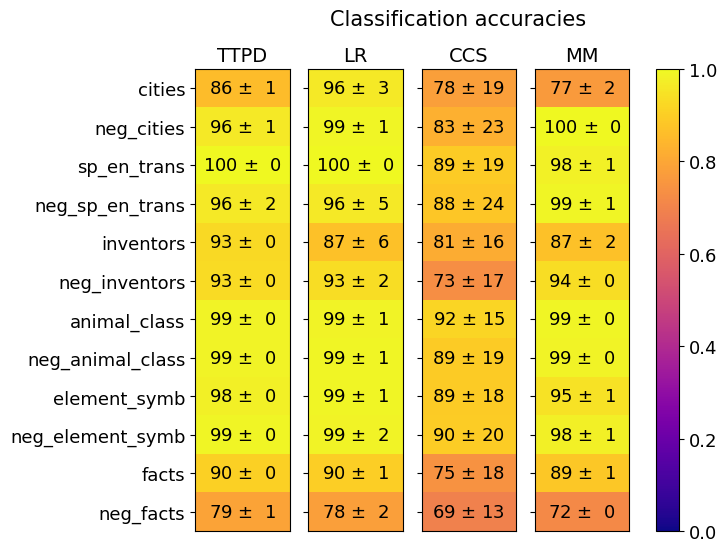

In [5]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(7, 6), ncols=4)
titles = ["TTPD", "LR", "CCS", "MM"]

for t, (ax, key) in enumerate(zip((ax1, ax2, ax3, ax4), (TTPD, LRProbe, CCSProbe, MMProbe))):
    grid = [[stat_results[key]['mean'][dataset]] for dataset in train_sets]
    grid_std = [[stat_results[key]['std'][dataset]] for dataset in train_sets]
    im = ax.imshow(grid, vmin=0, vmax=1, cmap='plasma', aspect='auto')
    
    for i, row in enumerate(grid):
        for j, val in enumerate(row):
            ax.text(j, i, f'{round(grid[i][j] * 100):2d} $\pm$ {round(grid_std[i][j] * 100):2d}', ha='center', va='center', fontsize=13)
    
    ax.set_yticks(range(len(train_sets)))
    ax.set_xticks([])
    
    ax.set_title(titles[t], fontsize=14)

ax1.set_yticklabels(train_sets, fontsize=13)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])

cbar = fig.colorbar(im, ax=[ax1, ax2, ax3, ax4])
cbar.ax.tick_params(labelsize=13)

fig.suptitle("Classification accuracies", fontsize=15)
plt.show()

### Generalisation to logical conjunctions and disjunctions

In [6]:
# compare TTPD, LR, CCS and MM on logical conjunctions and disjunctions
val_sets = ["cities_conj", "cities_disj", "sp_en_trans_conj","sp_en_trans_disj",
             "inventors_conj", "inventors_disj", "animal_class_conj", "animal_class_disj",
               "element_symb_conj", "element_symb_disj", "facts_conj", "facts_disj",
            "common_claim_true_false", "counterfact_true_false"]


probe_types = [TTPD, LRProbe, CCSProbe, MMProbe]
results = {TTPD: defaultdict(list), LRProbe: defaultdict(list), CCSProbe: defaultdict(list), MMProbe: defaultdict(list)}
num_iter = 20

total_iterations = len(probe_types) * num_iter
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_type in probe_types:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family, model_size,
                                                                             model_type, layer)
            if probe_type == TTPD:
                probe = TTPD.from_data(acts_centered, acts, labels, polarities)
            if probe_type == LRProbe:
                probe = LRProbe.from_data(acts, labels)
            if probe_type == CCSProbe:
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
            if probe_type == MMProbe:
                probe = MMProbe.from_data(acts, labels)

            # evaluate classification accuracy on validation datasets
            dm = DataManager()
            for val_set in val_sets:
                dm.add_dataset(val_set, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                acts, labels = dm.data[val_set]
                
                # classifier specific predictions
                if probe_type == CCSProbe:
                    acts = acts - (mean_affirm + mean_neg)/2
                predictions = probe.pred(acts)
                results[probe_type][val_set].append((predictions == labels).float().mean().item())
            pbar.update(1)

stat_results = compute_statistics(results)

# Compute mean accuracies and standard deviations for each probe type
probe_accuracies = compute_average_accuracies(results, num_iter)

for probe_type, stats in probe_accuracies.items():
    print(f"{probe_type}:")
    print(f"  Mean Accuracy: {stats['mean']*100:.2f}%")
    print(f"  Standard Deviation of the mean accuracy: {stats['std_dev']*100:.2f}%")

Training and evaluating classifiers: 100%|██████████| 80/80 [03:19<00:00,  2.50s/it]

TTPD:
  Mean Accuracy: 75.36%
  Standard Deviation of the mean accuracy: 0.34%
LRProbe:
  Mean Accuracy: 70.25%
  Standard Deviation of the mean accuracy: 2.56%
CCSProbe:
  Mean Accuracy: 72.96%
  Standard Deviation of the mean accuracy: 3.76%
MMProbe:
  Mean Accuracy: 74.35%
  Standard Deviation of the mean accuracy: 0.37%


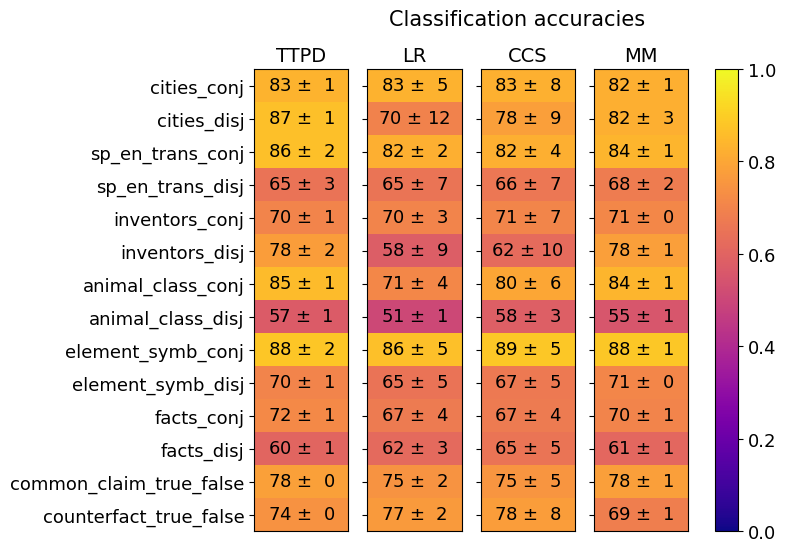

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(7, 6), ncols=4)
titles = ["TTPD", "LR", "CCS", "MM"]

for t, (ax, key) in enumerate(zip((ax1, ax2, ax3, ax4), (TTPD, LRProbe, CCSProbe, MMProbe))):
    grid = [[stat_results[key]['mean'][dataset]] for dataset in val_sets]
    grid_std = [[stat_results[key]['std'][dataset]] for dataset in val_sets]
    im = ax.imshow(grid, vmin=0, vmax=1, cmap='plasma', aspect='auto')
    
    for i, row in enumerate(grid):
        for j, val in enumerate(row):
            ax.text(j, i, f'{round(grid[i][j] * 100):2d} $\pm$ {round(grid_std[i][j] * 100):2d}', ha='center', va='center', fontsize=13)
    
    ax.set_yticks(range(len(val_sets)))
    ax.set_xticks([])
    
    ax.set_title(titles[t], fontsize=14)

ax1.set_yticklabels(val_sets, fontsize=13)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])

cbar = fig.colorbar(im, ax=[ax1, ax2, ax3, ax4])
cbar.ax.tick_params(labelsize=13)

fig.suptitle("Classification accuracies", fontsize=15)
plt.show()

### Generalisation to German statements

In [8]:
# compare TTPD, LR, CCS and MM on statements translated to german
val_sets = ["cities_de", "neg_cities_de", "sp_en_trans_de", "neg_sp_en_trans_de", "inventors_de", "neg_inventors_de", "animal_class_de",
                  "neg_animal_class_de", "element_symb_de", "neg_element_symb_de", "facts_de", "neg_facts_de"]


probe_types = [TTPD, LRProbe, CCSProbe, MMProbe]
results = {TTPD: defaultdict(list), LRProbe: defaultdict(list), CCSProbe: defaultdict(list), MMProbe: defaultdict(list)}
num_iter = 20

total_iterations = len(probe_types) * num_iter
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_type in probe_types:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family, model_size,
                                                                                           model_type, layer)
            if probe_type == TTPD:
                probe = TTPD.from_data(acts_centered, acts, labels, polarities)
            if probe_type == LRProbe:
                probe = LRProbe.from_data(acts, labels)
            if probe_type == CCSProbe:
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
            if probe_type == MMProbe:
                probe = MMProbe.from_data(acts, labels)

            # evaluate classification accuracy on validation datasets
            dm = DataManager()
            for val_set in val_sets:
                dm.add_dataset(val_set, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                acts, labels = dm.data[val_set]
                
                # classifier specific predictions
                if probe_type == CCSProbe:
                    acts = acts - (mean_affirm + mean_neg)/2
                predictions = probe.pred(acts)
                
                results[probe_type][val_set].append((predictions == labels).float().mean().item())
            pbar.update(1)

stat_results = compute_statistics(results)

# Compute mean accuracies and standard deviations for each probe type
probe_accuracies = compute_average_accuracies(results, num_iter)

for probe_type, stats in probe_accuracies.items():
    print(f"{probe_type}:")
    print(f"  Mean Accuracy: {stats['mean']*100:.2f}%")
    print(f"  Standard Deviation of the mean accuracy: {stats['std_dev']*100:.2f}%")

Training and evaluating classifiers: 100%|██████████| 80/80 [00:52<00:00,  1.53it/s]

TTPD:
  Mean Accuracy: 87.54%
  Standard Deviation of the mean accuracy: 0.37%
LRProbe:
  Mean Accuracy: 89.46%
  Standard Deviation of the mean accuracy: 1.04%
CCSProbe:
  Mean Accuracy: 83.16%
  Standard Deviation of the mean accuracy: 13.25%
MMProbe:
  Mean Accuracy: 82.76%
  Standard Deviation of the mean accuracy: 1.45%


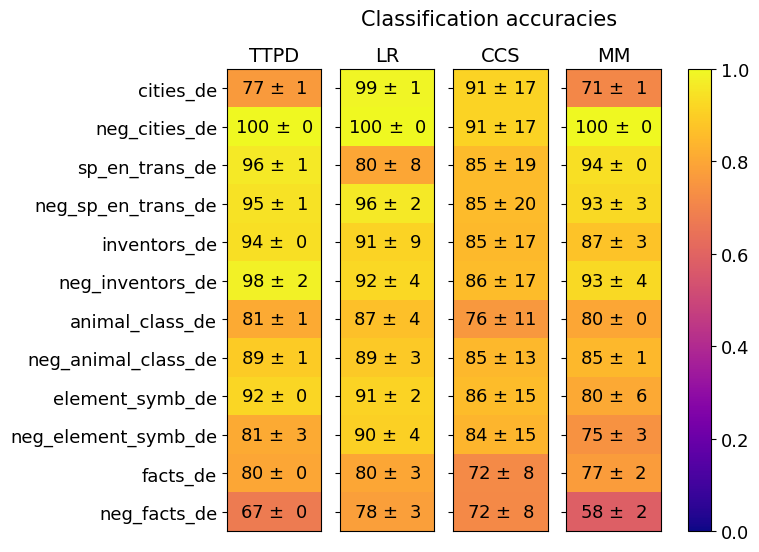

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(7, 6), ncols=4)
titles = ["TTPD", "LR", "CCS", "MM"]

for t, (ax, key) in enumerate(zip((ax1, ax2, ax3, ax4), (TTPD, LRProbe, CCSProbe, MMProbe))):
    grid = [[stat_results[key]['mean'][dataset]] for dataset in val_sets]
    grid_std = [[stat_results[key]['std'][dataset]] for dataset in val_sets]
    im = ax.imshow(grid, vmin=0, vmax=1, cmap='plasma', aspect='auto')
    
    for i, row in enumerate(grid):
        for j, val in enumerate(row):
            ax.text(j, i, f'{round(grid[i][j] * 100):2d} $\pm$ {round(grid_std[i][j] * 100):2d}', ha='center', va='center', fontsize=13)
    
    ax.set_yticks(range(len(val_sets)))
    ax.set_xticks([])
    ax.set_title(titles[t], fontsize=14)

ax1.set_yticklabels(val_sets, fontsize=13)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])

cbar = fig.colorbar(im, ax=[ax1, ax2, ax3, ax4])
cbar.ax.tick_params(labelsize=13)

fig.suptitle("Classification accuracies", fontsize=15)
plt.show()

### Displaying generalisation to Conjunctions, Disjunctions and German statements in one table

In [11]:
# Define the validation sets and the probe types
val_sets = ["cities_conj", "cities_disj", "sp_en_trans_conj","sp_en_trans_disj",
             "inventors_conj", "inventors_disj", "animal_class_conj", "animal_class_disj",
               "element_symb_conj", "element_symb_disj", "facts_conj", "facts_disj", "cities_de", "neg_cities_de", "sp_en_trans_de", "neg_sp_en_trans_de", "inventors_de", "neg_inventors_de", "animal_class_de",
                  "neg_animal_class_de", "element_symb_de", "neg_element_symb_de", "facts_de", "neg_facts_de",
            "common_claim_true_false", "counterfact_true_false"]

probe_types = [TTPD, LRProbe, CCSProbe, MMProbe]
results = {TTPD: defaultdict(list), LRProbe: defaultdict(list), CCSProbe: defaultdict(list), MMProbe: defaultdict(list)}
num_iter = 20

# Training and evaluating classifiers
total_iterations = len(probe_types) * num_iter
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar:
    for probe_type in probe_types:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family, model_size,
                                                                                           model_type, layer)
            if probe_type == TTPD:
                probe = TTPD.from_data(acts_centered, acts, labels, polarities)
            if probe_type == LRProbe:
                probe = LRProbe.from_data(acts, labels)
            if probe_type == CCSProbe:
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
            if probe_type == MMProbe:
                probe = MMProbe.from_data(acts, labels)

            # evaluate classification accuracy on validation datasets
            dm = DataManager()
            for val_set in val_sets:
                dm.add_dataset(val_set, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                acts, labels = dm.data[val_set]
                
                # classifier specific predictions
                if probe_type == CCSProbe:
                    acts = acts - (mean_affirm + mean_neg)/2
                predictions = probe.pred(acts)
                results[probe_type][val_set].append((predictions == labels).float().mean().item())
            pbar.update(1)

Training and evaluating classifiers: 100%|██████████| 80/80 [03:26<00:00,  2.59s/it]


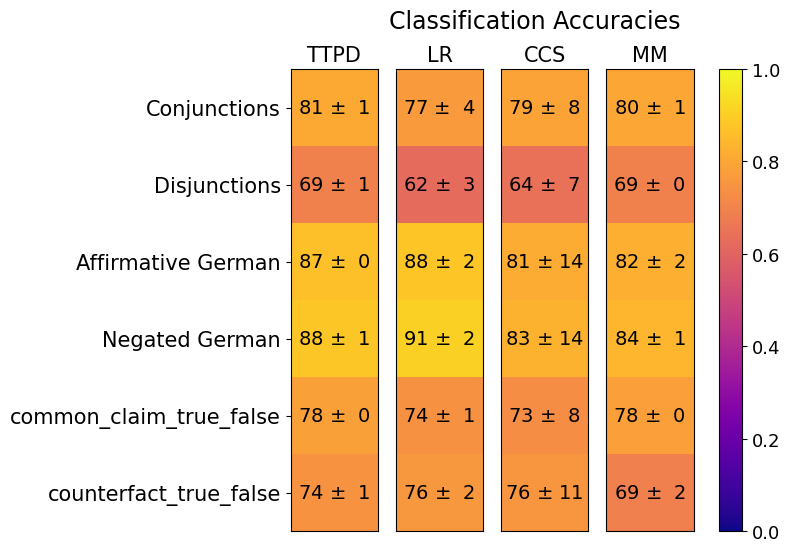

In [12]:
# Define the groups
groups = {
    'Conjunctions': [dataset for dataset in val_sets if dataset.endswith('_conj')],
    'Disjunctions': [dataset for dataset in val_sets if dataset.endswith('_disj')],
    'Affirmative German': [dataset for dataset in val_sets if dataset.endswith('_de') and not dataset.startswith('neg_')],
    'Negated German': [dataset for dataset in val_sets if dataset.startswith('neg_') and dataset.endswith('_de')],
    'common_claim_true_false': ['common_claim_true_false'],
    'counterfact_true_false': ['counterfact_true_false']
}

# Initialize group results
group_results = {probe_type: {group_name: [] for group_name in groups} for probe_type in probe_types}

# Process results to compute mean accuracies per group per classifier
for probe_type in probe_types:
    for n in range(num_iter):
        for group_name, group_datasets in groups.items():
            accuracies = []
            for dataset in group_datasets:
                accuracy = results[probe_type][dataset][n]
                accuracies.append(accuracy)
            mean_accuracy = sum(accuracies) / len(accuracies)
            group_results[probe_type][group_name].append(mean_accuracy)

# Compute statistics
stat_group_results = {probe_type: {'mean': {}, 'std': {}} for probe_type in probe_types}

for probe_type in probe_types:
    for group_name in groups:
        accuracies = group_results[probe_type][group_name]
        mean_accuracy = np.mean(accuracies)
        std_accuracy = np.std(accuracies)
        stat_group_results[probe_type]['mean'][group_name] = mean_accuracy
        stat_group_results[probe_type]['std'][group_name] = std_accuracy

# Map probe types to classifier names
probe_type_to_name = {
    TTPD: 'TTPD',
    LRProbe: 'LR',
    CCSProbe: 'CCS',
    MMProbe: 'MM'
}

# Create DataFrames for mean accuracies and standard deviations
group_names = ['Conjunctions', 'Disjunctions', 'Affirmative German', 'Negated German', 'common_claim_true_false', 'counterfact_true_false']
classifier_names = ['TTPD', 'LR', 'CCS', 'MM']

mean_df = pd.DataFrame(index=group_names, columns=classifier_names)
std_df = pd.DataFrame(index=group_names, columns=classifier_names)

for probe_type in probe_types:
    classifier_name = probe_type_to_name[probe_type]
    for group_name in group_names:
        mean_accuracy = stat_group_results[probe_type]['mean'][group_name]
        std_accuracy = stat_group_results[probe_type]['std'][group_name]
        mean_df.loc[group_name, classifier_name] = mean_accuracy
        std_df.loc[group_name, classifier_name] = std_accuracy

fig, axes = plt.subplots(figsize=(6.5, 6), ncols=4)

for idx, classifier_name in enumerate(classifier_names):
    ax = axes[idx]
    mean_values = mean_df[classifier_name].values.astype(float)
    std_values = std_df[classifier_name].values.astype(float)
    
    # Create heatmap
    im = ax.imshow(mean_values[:, np.newaxis], vmin=0, vmax=1, cmap='plasma', aspect='auto')
    
    # Annotate the heatmap with mean accuracies and standard deviations
    for i in range(len(group_names)):
        mean_accuracy = mean_values[i]
        std_accuracy = std_values[i]
        ax.text(0, i, f'{round(mean_accuracy * 100):2d} $\pm$ {round(std_accuracy * 100):2d}', ha='center', va='center', fontsize=14)
    
    # Set ticks and labels
    ax.set_xticks([])
    if idx == 0:
        ax.set_yticks(np.arange(len(group_names)))
        ax.set_yticklabels(group_names, fontsize=15)
    else:
        ax.set_yticks([])
    ax.set_title(classifier_name, fontsize=15)

# Add colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist())
cbar.ax.tick_params(labelsize=13)

fig.suptitle("Classification Accuracies", fontsize=17)
plt.show()

### Real world scenarios / lies

In [13]:
probe_types = [TTPD, LRProbe, CCSProbe, MMProbe]
results = {TTPD: [], LRProbe: [], CCSProbe: [], MMProbe: []}
num_iter = 50

total_iterations = len(probe_types) * num_iter
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_type in probe_types:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family,
                                                                                           model_size, model_type,layer)
            if probe_type == TTPD:
                probe = TTPD.from_data(acts_centered, acts, labels, polarities)
            if probe_type == LRProbe:
                probe = LRProbe.from_data(acts, labels)
            if probe_type == CCSProbe:
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
            if probe_type == MMProbe:
                probe = MMProbe.from_data(acts, labels)

            # evaluate classification accuracy on real world scenarios
            dm = DataManager()
            real_world_dataset = "real_world_scenarios/all_unambiguous_replies"
            dm.add_dataset(real_world_dataset, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
            acts, labels = dm.data[real_world_dataset]
            
            # classifier specific predictions
            if probe_type == CCSProbe:
                acts = acts - (mean_affirm + mean_neg)/2

            predictions = probe.pred(acts)
            results[probe_type].append((predictions == labels).float().mean().item())
            pbar.update(1)

for probe_type in probe_types:
    mean = np.mean(results[probe_type])
    std = np.std(results[probe_type])
    print(f"{probe_type.__name__}:")
    print(f"  Mean Accuracy: {mean*100:.2f}%")
    print(f"  Standard Deviation: {std*100:.2f}%")

Training and evaluating classifiers: 100%|██████████| 200/200 [02:02<00:00,  1.63it/s]

TTPD:
  Mean Accuracy: 93.75%
  Standard Deviation: 1.25%
LRProbe:
  Mean Accuracy: 76.40%
  Standard Deviation: 7.13%
CCSProbe:
  Mean Accuracy: 72.54%
  Standard Deviation: 11.27%
MMProbe:
  Mean Accuracy: 90.65%
  Standard Deviation: 1.56%
